# Notes
* 7 speakers
    * 'cc','cl', 'gg', 'jg', 'mf', 'mk', 'mm'
* 15 emotions
    * 'anxiety', 'boredom', 'cold-anger', 'contempt', 'despair', 'disgust', 'elation', 'happy', 'hot-anger', 'interest', 'neutral', 'panic', 'pride', 'sadness', 'shame'
    

In [1]:
#!git clone https://github.com/audeering/opensmile.git

In [2]:
#!brew install cmake

In [3]:
%cd opensmile

In [4]:
#!bash build.sh

In [5]:
#!ls

In [6]:
#!ls -l config/is09-13

In [7]:
#!find ../hw3_speech_files/ -type f -name "*.wav" -exec sh -c 'for file; do base=$(basename "$file" ".wav");  ./build/progsrc/smilextract/SMILExtract -l 1 -C ./config/is09-13/IS09_emotion.conf -I "$file" -instname "$base" -csvoutput "../baseline_features/${base}.csv";  done' sh {} +

In [8]:
#! find ../hw3_speech_files/ -type f -name "*.wav" -exec sh -c 'for file; do base=$(basename "$file" ".wav"); ./build/progsrc/smilextract/SMILExtract -l 1 -C ./config/is09-13/IS09_emotion.conf -I $file -classlabel "$classlabel" -csvoutput "../baseline_features/${base}.csv"; done' sh {} +

In [9]:
import pandas as pd
import os
import glob

input_dir = "../baseline_features/"  
output_file = "combined_features.csv"

csv_files = glob.glob(os.path.join(input_dir, "*.csv"))

combined_df = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

combined_df.to_csv(output_file, index=False)

print(f"Combined {len(csv_files)} CSV files into {output_file}")


Combined 2324 CSV files into combined_features.csv


In [10]:
open_smile=pd.read_csv("combined_features.csv", sep=";")
print(open_smile.info())

#replace 0s with NaN to help with training
open_smile.fillna(0.0, inplace=True)

open_smile.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324 entries, 0 to 2323
Columns: 386 entries, name to F0_sma_de_kurtosis
dtypes: float64(320), int64(65), object(1)
memory usage: 6.8+ MB
None


,name,frameTime,pcm_RMSenergy_sma_max,pcm_RMSenergy_sma_min,pcm_RMSenergy_sma_range,pcm_RMSenergy_sma_maxPos,pcm_RMSenergy_sma_minPos,pcm_RMSenergy_sma_amean,pcm_RMSenergy_sma_linregc1,pcm_RMSenergy_sma_linregc2,...,F0_sma_de_range,F0_sma_de_maxPos,F0_sma_de_minPos,F0_sma_de_amean,F0_sma_de_linregc1,F0_sma_de_linregc2,F0_sma_de_linregerrQ,F0_sma_de_stddev,F0_sma_de_skewness,F0_sma_de_kurtosis
0,'mm_001_happy_2353.51_three-hundred-nine',0.0,0.010760,0.000064,0.010696,111,165,0.002748,-8.324649e-06,0.003498,...,181.94580,85,92,8.510025e-08,-0.033835,3.045167,1062.67900,32.646660,-0.090631,4.245496
1,'mm_001_panic_3395.30_one-thousand-three',0.0,0.076285,0.000034,0.076251,32,134,0.011488,-1.106844e-04,0.019789,...,245.74430,85,68,3.852591e-08,-0.097880,7.340973,1683.38700,41.250330,0.000596,4.717154
2,'cc_001_panic_861.97_Two-thousand-five',0.0,0.020006,0.000010,0.019996,39,1853,0.000425,-2.645859e-07,0.000788,...,181.56010,1909,617,-9.201901e-09,-0.000025,0.034964,213.41610,14.608780,-0.116606,17.215480
3,'mf_001_contempt_3901.86_November-first',0.0,0.015069,0.000043,0.015026,85,0,0.005252,2.256441e-05,0.004067,...,87.32532,62,71,4.048617e-08,-0.029053,1.525273,188.63710,13.763260,-0.312293,6.684447
4,'cl_001_interest_1035.82_Ten-thousand-one',0.0,0.016625,0.000111,0.016514,55,137,0.002422,-3.115808e-05,0.004572,...,74.25951,95,99,1.372193e-08,-0.001866,0.128773,39.98518,6.323827,-0.006288,25.196500


In [11]:
clean_name = open_smile['name'][0].strip("[]'\"")
split_name = clean_name.split("_")
split_name

['mm', '001', 'happy', '2353.51', 'three-hundred-nine']

In [12]:
#Normalize using method 2
def open_norm(df):
    speakers= df['name'].apply(lambda l: l.split("_")[0].strip("[]'\""))
    emotions= df['name'].apply(lambda l: l.split("_")[2].strip("[]'\""))
    df.insert(1, 'emotion', emotions)
    df.insert(2, 'speaker', speakers)
    
    #get bneutral utterances and normalize for each speaker
    for speaker in df['speaker'].unique():
        neutral_df=df[(df['speaker']==speaker) & (df['emotion']=='neutral')]
        
        feature_cols= df.columns[3:]
        for col in feature_cols:
            if str(col) not in ['speaker', 'emotion']:
                speaker_mean= neutral_df[col].mean()
                df[col]= df[col] - speaker_mean
    return df

In [13]:
smile_norm=open_norm(open_smile)
smile_norm

,name,emotion,speaker,frameTime,pcm_RMSenergy_sma_max,pcm_RMSenergy_sma_min,pcm_RMSenergy_sma_range,pcm_RMSenergy_sma_maxPos,pcm_RMSenergy_sma_minPos,pcm_RMSenergy_sma_amean,...,F0_sma_de_range,F0_sma_de_maxPos,F0_sma_de_minPos,F0_sma_de_amean,F0_sma_de_linregc1,F0_sma_de_linregc2,F0_sma_de_linregerrQ,F0_sma_de_stddev,F0_sma_de_skewness,F0_sma_de_kurtosis
0,'mm_001_happy_2353.51_three-hundred-nine',happy,mm,0.0,-0.036211,-0.000014,-0.036197,78.0,72.222222,-0.005396,...,13.346391,46.111111,39.777778,9.411793e-08,-0.014334,1.637743,604.137643,12.327299,-0.478294,-7.692416
1,'mm_001_panic_3395.30_one-thousand-three',panic,mm,0.0,0.029315,-0.000044,0.029359,-1.0,41.222222,0.003344,...,77.144891,46.111111,15.777778,4.754359e-08,-0.078379,5.933549,1224.845643,20.930969,-0.387068,-7.220758
2,'cc_001_panic_861.97_Two-thousand-five',panic,cc,0.0,-0.026964,-0.000068,-0.026896,6.0,1760.222222,-0.007719,...,12.960691,1870.111111,564.777778,-1.842239e-10,0.019476,-1.372460,-245.125257,-5.710581,-0.504269,5.277568
3,'mf_001_contempt_3901.86_November-first',contempt,mf,0.0,-0.031901,-0.000035,-0.031866,52.0,-92.777778,-0.002893,...,-81.274089,23.111111,18.777778,4.950385e-08,-0.009552,0.117849,-269.904257,-6.556101,-0.699956,-5.253465
4,'cl_001_interest_1035.82_Ten-thousand-one',interest,cl,0.0,-0.030345,0.000033,-0.030379,22.0,44.222222,-0.005722,...,-94.339899,56.111111,46.777778,2.273961e-08,0.017635,-1.278651,-418.556177,-13.995534,-0.393951,13.258588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319,'gg_001_anxiety_861.72_Three-thousand-eight',anxiety,gg,0.0,-0.022373,-0.000018,-0.022355,4.0,-2.777778,-0.003906,...,46.652691,-34.888889,-43.222222,6.623814e-08,-0.008586,-0.017108,199.947643,5.354489,-0.139077,1.651818
2320,'cl_001_cold-anger_499.97_March-twenty-third',cold-anger,cl,0.0,0.063760,0.000017,0.063743,28.0,-67.777778,0.001575,...,-84.113069,39.111111,73.777778,-1.037178e-08,0.015984,-1.117238,-342.813757,-9.560361,-0.405068,-1.692562
2321,'mm_001_elation_2227.76_nineteen-hundred',elation,mm,0.0,0.011188,0.000026,0.011161,20.0,-89.777778,-0.000509,...,-7.602509,-28.888889,-35.222222,1.113053e-08,-0.037956,2.413479,416.147443,9.339169,-0.271780,-7.857798
2322,'jg_001_panic_425.32_August-fourteenth',panic,jg,0.0,-0.014303,-0.000023,-0.014280,42.0,106.222222,-0.006221,...,-168.599409,-38.888889,-52.222222,9.017677e-09,0.019501,-1.407424,-458.541357,-20.319361,-0.387663,-11.937912


In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

#Remove one speaker for cross validation
cols=smile_norm.columns
scores=pd.DataFrame(columns=['speaker', 'accuracy', 'F1', 'n'])
i=0
reports=[]
for speaker in smile_norm['speaker'].unique():
    # Filter the data for the current speaker
    test = smile_norm[smile_norm['speaker'] == speaker]
    # Filter the remaining data for training
    train = smile_norm[smile_norm['speaker'] != speaker]
    features= list(train.columns[4:])

    X_train= train[features]
    y_train= train['emotion']

    X_test= test[features]
    y_test= test['emotion']
    
    #only OpenSmile
    rf_classifier = RandomForestClassifier(random_state=42, n_estimators=100, verbose=0)
    rf_classifier.fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    n=test.shape[0]
    
    row=[speaker, accuracy, f1, n]
    scores.loc[i]=row
    i+=1
    reports.append(classification_report(y_test, y_pred, zero_division=0))



In [58]:
len(features)
len(set(features))

384

In [24]:
scores

,speaker,accuracy,F1,n
0,mm,0.261589,0.244635,302
1,cc,0.207547,0.216585,265
2,mf,0.170569,0.153532,299
3,cl,0.184783,0.167348,368
4,mk,0.156171,0.129367,397
5,jg,0.150183,0.140944,273
6,gg,0.235714,0.193932,420


In [25]:
#RF Aggregated Averages

assert(scores['n'].sum()==2324)
n_total= scores['n'].sum()
accuracy=0
F1=0
#will run 7 times
for index, row in scores.iterrows():
    speaker= row['speaker']
    acc= row['accuracy']
    f1= row['F1']
    n= row['n']
    accuracy+= acc * n
    F1+= f1 * n

aggregated_accuracy= accuracy/n_total
aggregated_F1= F1/n_total

print("Aggregated Average Accuracry: ", aggregated_accuracy)
print("Aggreaged F1: ", aggregated_F1)

Aggregated Average Accuracry:  0.19578313253012047
Aggreaged F1:  0.17644250308557874


In [34]:
import markdown
for report in reports:
    print(markdown.markdown(report))

<pre><code>          precision    recall  f1-score   support

 anxiety       0.57      0.33      0.42        39
 boredom       0.12      0.05      0.07        19
</code></pre>
<p>cold-anger       0.10      0.05      0.07        20
    contempt       0.10      0.05      0.07        19
     despair       0.14      0.11      0.12        18
     disgust       0.29      0.26      0.27        23
     elation       0.31      0.21      0.25        19
       happy       0.39      0.50      0.44        18
   hot-anger       0.40      0.38      0.39        16
    interest       0.24      0.48      0.32        21
     neutral       0.00      0.00      0.00         9
       panic       0.44      0.14      0.22        28
       pride       0.27      0.21      0.24        19
     sadness       0.12      0.29      0.17        17
       shame       0.23      0.76      0.35        17</p>
<pre><code>accuracy                           0.26       302
</code></pre>
<p>macro avg       0.25      0.26      0.2

In [166]:
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score

#Remove one speaker for cross validation
cols=smile_norm.columns
scores_svm=pd.DataFrame(columns=['speaker', 'accuracy', 'F1', 'n'])
i=0
for speaker in smile_norm['speaker'].unique():
    # Filter the data for the current speaker
    test = smile_norm[smile_norm['speaker'] == speaker]
    # Filter the remaining data for training
    train = smile_norm[smile_norm['speaker'] != speaker]
    features= list(train.columns[4:])

    X_train= train[features]
    y_train= train['emotion']

    X_test= test[features]
    y_test= test['emotion']
    
    #only OpenSmile
    svm_classifier = svm.SVC(kernel='rbf', C=10, gamma='scale', random_state=43)
    svm_classifier.fit(X_train, y_train)
    print(f"{i}th iteration done")
    y_pred = svm_classifier.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    n=test.shape[0]
    
    row=[speaker, accuracy, f1, n]
    scores_svm.loc[i]=row
    i+=1


0th iteration done
1th iteration done
2th iteration done
3th iteration done
4th iteration done
5th iteration done
6th iteration done


In [167]:
scores_svm

,speaker,accuracy,F1,n
0,mm,0.135762,0.077793,302
1,cc,0.094340,0.058617,265
2,mf,0.130435,0.065504,299
3,cl,0.078804,0.031958,368
4,mk,0.100756,0.060938,397
5,jg,0.109890,0.087482,273
6,gg,0.109524,0.057588,420


In [168]:
#SVM Aggregated Averages

assert(scores_svm['n'].sum()==2324)
n_total= scores_svm['n'].sum()
accuracy=0
F1=0
#will run 7 times
for index, row in scores_svm.iterrows():
    speaker= row['speaker']
    acc= row['accuracy']
    f1= row['F1']
    n= row['n']
    accuracy+= acc * n
    F1+= f1 * n

aggregated_accuracy= accuracy/n_total
aggregated_F1= F1/n_total

print("Aggregated Average Accuracry: ", aggregated_accuracy)
print("Aggreaged F1: ", aggregated_F1)

Aggregated Average Accuracry:  0.10757314974182444
Aggreaged F1:  0.061374998854800786


In [99]:
#try neural nets
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.optimizers.legacy import Adam
from sklearn import svm
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def build_mlp_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

#Remove one speaker for cross validation
cols=smile_norm.columns
scores_nn=pd.DataFrame(columns=['speaker', 'accuracy', 'F1', 'n'])
i=0
for speaker in smile_norm['speaker'].unique():
    # Filter the data for the current speaker
    test = smile_norm[smile_norm['speaker'] == speaker]
    # Filter the remaining data for training
    train = smile_norm[smile_norm['speaker'] != speaker]
    features= list(train.columns[4:])

    X_train= train[features]
    y_train= train['emotion']

    X_test= test[features]
    y_test= test['emotion']
    
    #only OpenSmile

    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.transform(y_test)
    
    print("Shapes before scaling:")
    print("X_train:", X_train.shape)
    print("X_test:", X_test.shape)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    num_classes = len(label_encoder.classes_)
    model = build_mlp_model(input_shape=X_train.shape[1], num_classes=num_classes)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=50, batch_size=32)

    print(f"{i}th iteration done")
    y_val_pred = np.argmax(model.predict(X_test), axis=1)
    
    accuracy = accuracy_score(y_test, y_val_pred)
    f1 = f1_score(y_test, y_val_pred, average='weighted')

    print("Validation F1 Score (macro):", f1)
    print("Validation Accuracy:", accuracy)
    n=test.shape[0]
    
    row=[speaker, accuracy, f1, n]
    scores_nn.loc[i]=row
    i+=1
    if f1 < 0.20 and i < 1: 
        break


Shapes before scaling:
X_train: (2022, 384)
X_test: (302, 384)
Epoch 1/50
64/64 [==============================] - 1s 7ms/step - loss: 3.6416 - accuracy: 0.0826
Epoch 2/50
64/64 [==============================] - 0s 5ms/step - loss: 3.0846 - accuracy: 0.1202
Epoch 3/50
64/64 [==============================] - 0s 5ms/step - loss: 2.7976 - accuracy: 0.1667
Epoch 4/50
64/64 [==============================] - 0s 5ms/step - loss: 2.5942 - accuracy: 0.1919
Epoch 5/50
64/64 [==============================] - 0s 5ms/step - loss: 2.4373 - accuracy: 0.2191
Epoch 6/50
64/64 [==============================] - 0s 5ms/step - loss: 2.3084 - accuracy: 0.2527
Epoch 7/50
64/64 [==============================] - 0s 5ms/step - loss: 2.2056 - accuracy: 0.2760
Epoch 8/50
64/64 [==============================] - 0s 5ms/step - loss: 2.1209 - accuracy: 0.3056
Epoch 9/50
64/64 [==============================] - 0s 5ms/step - loss: 2.0392 - accuracy: 0.3249
Epoch 10/50
64/64 [==============================] - 0s

In [100]:
scores_nn

,speaker,accuracy,F1,n
0,mm,0.254967,0.227513,302
1,cc,0.207547,0.190020,265
2,mf,0.207358,0.188525,299
3,cl,0.171196,0.182659,368
4,mk,0.196474,0.180407,397
5,jg,0.146520,0.142839,273
6,gg,0.276190,0.246438,420


In [101]:
assert(scores_nn['n'].sum()==2324)
n_total= scores_nn['n'].sum()
accuracy=0
F1=0
#will run 7 times
for index, row in scores_nn.iterrows():
    speaker= row['speaker']
    acc= row['accuracy']
    f1= row['F1']
    n= row['n']
    accuracy+= acc * n
    F1+= f1 * n

aggregated_accuracy= accuracy/n_total
aggregated_F1= F1/n_total

print("Aggregated Average Accuracry: ", aggregated_accuracy)
print("Aggreaged F1: ", aggregated_F1)

Aggregated Average Accuracry:  0.2112736660929432
Aggreaged F1:  0.1965456673428223


In [103]:
#try neural nets
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.optimizers.legacy import Adam
from sklearn import svm
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def build_mlp_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Dense(256, activation='sigmoid', input_shape=(input_shape,)),
        layers.Dense(128, activation='sigmoid'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

#Remove one speaker for cross validation
cols=smile_norm.columns
scores_nn=pd.DataFrame(columns=['speaker', 'accuracy', 'F1', 'n'])
i=0
for speaker in smile_norm['speaker'].unique():
    # Filter the data for the current speaker
    test = smile_norm[smile_norm['speaker'] == speaker]
    # Filter the remaining data for training
    train = smile_norm[smile_norm['speaker'] != speaker]
    features= list(train.columns[4:])

    X_train= train[features]
    y_train= train['emotion']

    X_test= test[features]
    y_test= test['emotion']
    
    #only OpenSmile

    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.transform(y_test)
    
    print("Shapes before scaling:")
    print("X_train:", X_train.shape)
    print("X_test:", X_test.shape)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    num_classes = len(label_encoder.classes_)
    model = build_mlp_model(input_shape=X_train.shape[1], num_classes=num_classes)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=50, batch_size=32)

    print(f"{i}th iteration done")
    y_val_pred = np.argmax(model.predict(X_test), axis=1)
    
    accuracy = accuracy_score(y_test, y_val_pred)
    f1 = f1_score(y_test, y_val_pred, average='weighted')

    print("Validation F1 Score (macro):", f1)
    print("Validation Accuracy:", accuracy)
    n=test.shape[0]
    
    row=[speaker, accuracy, f1, n]
    scores_nn.loc[i]=row
    i+=1
    if f1 < 0.20 and i <= 1: 
        break

Shapes before scaling:
X_train: (2022, 384)
X_test: (302, 384)
Epoch 1/50
64/64 [==============================] - 1s 7ms/step - loss: 2.7420 - accuracy: 0.0959
Epoch 2/50
64/64 [==============================] - 0s 5ms/step - loss: 2.6235 - accuracy: 0.1454
Epoch 3/50
64/64 [==============================] - 0s 5ms/step - loss: 2.5626 - accuracy: 0.1993
Epoch 4/50
64/64 [==============================] - 0s 5ms/step - loss: 2.5087 - accuracy: 0.2384
Epoch 5/50
64/64 [==============================] - 0s 5ms/step - loss: 2.4610 - accuracy: 0.2582
Epoch 6/50
64/64 [==============================] - 0s 5ms/step - loss: 2.4160 - accuracy: 0.2819
Epoch 7/50
64/64 [==============================] - 0s 5ms/step - loss: 2.3740 - accuracy: 0.2868
Epoch 8/50
64/64 [==============================] - 0s 5ms/step - loss: 2.3342 - accuracy: 0.3081
Epoch 9/50
64/64 [==============================] - 0s 5ms/step - loss: 2.2985 - accuracy: 0.3195
Epoch 10/50
64/64 [==============================] - 0s

In [104]:
scores_nn

,speaker,accuracy,F1,n
0,mm,0.314570,0.300965,302
1,cc,0.226415,0.191431,265
2,mf,0.260870,0.246341,299
3,cl,0.195652,0.172384,368
4,mk,0.158690,0.138877,397
5,jg,0.172161,0.160960,273
6,gg,0.254762,0.211075,420


In [105]:
assert(scores_nn['n'].sum()==2324)
n_total= scores_nn['n'].sum()
accuracy=0
F1=0
#will run 7 times
for index, row in scores_nn.iterrows():
    speaker= row['speaker']
    acc= row['accuracy']
    f1= row['F1']
    n= row['n']
    accuracy+= acc * n
    F1+= f1 * n

aggregated_accuracy= accuracy/n_total
aggregated_F1= F1/n_total

print("Aggregated Average Accuracry: ", aggregated_accuracy)
print("Aggreaged F1: ", aggregated_F1)

Aggregated Average Accuracry:  0.22461273666092943
Aggreaged F1:  0.20070659093503054


In [135]:
#try neural nets
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.layers import Dense, Dropout
from sklearn import svm
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def build_mlp_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Dense(512, activation='sigmoid', input_shape=(input_shape,)),
        Dropout(0.25),
        layers.Dense(256, activation='sigmoid'),
        Dropout(0.25),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

#Remove one speaker for cross validation
cols=smile_norm.columns
scores_nn=pd.DataFrame(columns=['speaker', 'accuracy', 'F1', 'n'])
i=0
for speaker in smile_norm['speaker'].unique():
    # Filter the data for the current speaker
    test = smile_norm[smile_norm['speaker'] == speaker]
    # Filter the remaining data for training
    train = smile_norm[smile_norm['speaker'] != speaker]
    features= list(train.columns[4:])

    X_train= train[features]
    y_train= train['emotion']

    X_test= test[features]
    y_test= test['emotion']
    
    #only OpenSmile

    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.transform(y_test)
    
    print("Shapes before scaling:")
    print("X_train:", X_train.shape)
    print("X_test:", X_test.shape)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    num_classes = len(label_encoder.classes_)
    model = build_mlp_model(input_shape=X_train.shape[1], num_classes=num_classes)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=50, batch_size=32)

    print(f"{i}th iteration done")
    y_val_pred = np.argmax(model.predict(X_test), axis=1)
    
    accuracy = accuracy_score(y_test, y_val_pred)
    f1 = f1_score(y_test, y_val_pred, average='weighted')

    print("Validation F1 Score (macro):", f1)
    print("Validation Accuracy:", accuracy)
    n=test.shape[0]
    
    row=[speaker, accuracy, f1, n]
    scores_nn.loc[i]=row
    i+=1
    if f1 < 0.25 and i <= 1: 
        break

Shapes before scaling:
X_train: (2022, 384)
X_test: (302, 384)
Epoch 1/50
64/64 [==============================] - 2s 18ms/step - loss: 2.7696 - accuracy: 0.0806
Epoch 2/50
64/64 [==============================] - 0s 6ms/step - loss: 2.6406 - accuracy: 0.1137
Epoch 3/50
64/64 [==============================] - 0s 6ms/step - loss: 2.5465 - accuracy: 0.1528
Epoch 4/50
64/64 [==============================] - 0s 5ms/step - loss: 2.4906 - accuracy: 0.1756
Epoch 5/50
64/64 [==============================] - 0s 5ms/step - loss: 2.4238 - accuracy: 0.1988
Epoch 6/50
64/64 [==============================] - 0s 6ms/step - loss: 2.3584 - accuracy: 0.2265
Epoch 7/50
64/64 [==============================] - 0s 6ms/step - loss: 2.3252 - accuracy: 0.2349
Epoch 8/50
64/64 [==============================] - 0s 6ms/step - loss: 2.2784 - accuracy: 0.2641
Epoch 9/50
64/64 [==============================] - 0s 6ms/step - loss: 2.2245 - accuracy: 0.2982
Epoch 10/50
64/64 [==============================] - 0

In [136]:
scores_nn

,speaker,accuracy,F1,n
0,mm,0.317881,0.303515,302
1,cc,0.230189,0.197647,265
2,mf,0.220736,0.210879,299
3,cl,0.182065,0.158217,368
4,mk,0.204030,0.184523,397
5,jg,0.168498,0.155623,273
6,gg,0.273810,0.239802,420


In [137]:
assert(scores_nn['n'].sum()==2324)
n_total= scores_nn['n'].sum()
accuracy=0
F1=0
#will run 7 times
for index, row in scores_nn.iterrows():
    speaker= row['speaker']
    acc= row['accuracy']
    f1= row['F1']
    n= row['n']
    accuracy+= acc * n
    F1+= f1 * n

aggregated_accuracy= accuracy/n_total
aggregated_F1= F1/n_total

print("Aggregated Average Accuracry: ", aggregated_accuracy)
print("Aggreaged F1: ", aggregated_F1)

Aggregated Average Accuracry:  0.2289156626506024
Aggreaged F1:  0.20730277458378488


In [178]:
#try neural nets
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.layers import Dense, Dropout
from sklearn import svm
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report

def build_mlp_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Dense(1024, activation='sigmoid', input_shape=(input_shape,)),
        Dropout(0.22),
        layers.Dense(512, activation='sigmoid'),
        Dropout(0.30),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

#Remove one speaker for cross validation
cols=smile_norm.columns
scores_nn=pd.DataFrame(columns=['speaker', 'accuracy', 'F1', 'n'])
i=0
best_f1=0
best_pred=None
for speaker in smile_norm['speaker'].unique():
    # Filter the data for the current speaker
    test = smile_norm[smile_norm['speaker'] == speaker]
    # Filter the remaining data for training
    train = smile_norm[smile_norm['speaker'] != speaker]
    features= list(train.columns[4:])

    X_train= train[features]
    y_train= train['emotion']

    X_test= test[features]
    y_test= test['emotion']
    
    #only OpenSmile

    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.transform(y_test)
    
    print("Shapes before scaling:")
    print("X_train:", X_train.shape)
    print("X_test:", X_test.shape)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    num_classes = len(label_encoder.classes_)
    model = build_mlp_model(input_shape=X_train.shape[1], num_classes=num_classes)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=50, batch_size=32)

    print(f"{i}th iteration done")
    y_val_pred = np.argmax(model.predict(X_test), axis=1)
    
    accuracy = accuracy_score(y_test, y_val_pred)
    f1 = f1_score(y_test, y_val_pred, average='weighted')
    if f1 > best_f1:
        best_f1=f1
        best_pred=y_val_pred
    print("Validation F1 Score (macro):", f1)
    print("Validation Accuracy:", accuracy)
    n=test.shape[0]
    
    row=[speaker, accuracy, f1, n]
    scores_nn.loc[i]=row
    reports.append(classification_report(y_test, y_val_pred, zero_division=0))
    
    i+=1
    

Shapes before scaling:
X_train: (2022, 384)
X_test: (302, 384)
Epoch 1/50
64/64 [==============================] - 1s 12ms/step - loss: 2.7599 - accuracy: 0.0905
Epoch 2/50
64/64 [==============================] - 0s 6ms/step - loss: 2.5823 - accuracy: 0.1370
Epoch 3/50
64/64 [==============================] - 0s 6ms/step - loss: 2.4794 - accuracy: 0.1845
Epoch 4/50
64/64 [==============================] - 0s 6ms/step - loss: 2.3720 - accuracy: 0.2216
Epoch 5/50
64/64 [==============================] - 0s 6ms/step - loss: 2.2802 - accuracy: 0.2651
Epoch 6/50
64/64 [==============================] - 0s 6ms/step - loss: 2.2280 - accuracy: 0.2839
Epoch 7/50
64/64 [==============================] - 0s 6ms/step - loss: 2.1598 - accuracy: 0.3136
Epoch 8/50
64/64 [==============================] - 0s 6ms/step - loss: 2.1029 - accuracy: 0.3442
Epoch 9/50
64/64 [==============================] - 0s 6ms/step - loss: 2.0409 - accuracy: 0.3635
Epoch 10/50
64/64 [==============================] - 0

In [179]:
scores_nn

,speaker,accuracy,F1,n
0,mm,0.301325,0.282579,302
1,cc,0.256604,0.232944,265
2,mf,0.224080,0.218448,299
3,cl,0.201087,0.186707,368
4,mk,0.193955,0.171204,397
5,jg,0.168498,0.155130,273
6,gg,0.271429,0.237667,420


In [180]:
assert(scores_nn['n'].sum()==2324)
n_total= scores_nn['n'].sum()
accuracy=0
F1=0
#will run 7 times
for index, row in scores_nn.iterrows():
    speaker= row['speaker']
    acc= row['accuracy']
    f1= row['F1']
    n= row['n']
    accuracy+= acc * n
    F1+= f1 * n

aggregated_accuracy= accuracy/n_total
aggregated_F1= F1/n_total

print("Aggregated Average Accuracry: ", aggregated_accuracy)
print("Aggreaged F1: ", aggregated_F1)

Aggregated Average Accuracry:  0.2310671256454389
Aggreaged F1:  0.21137334372806474


In [195]:
#All classification reports, even earlier ones
for report in reports:
    print((report))

              precision    recall  f1-score   support

     anxiety       0.57      0.33      0.42        39
     boredom       0.12      0.05      0.07        19
  cold-anger       0.10      0.05      0.07        20
    contempt       0.10      0.05      0.07        19
     despair       0.14      0.11      0.12        18
     disgust       0.29      0.26      0.27        23
     elation       0.31      0.21      0.25        19
       happy       0.39      0.50      0.44        18
   hot-anger       0.40      0.38      0.39        16
    interest       0.24      0.48      0.32        21
     neutral       0.00      0.00      0.00         9
       panic       0.44      0.14      0.22        28
       pride       0.27      0.21      0.24        19
     sadness       0.12      0.29      0.17        17
       shame       0.23      0.76      0.35        17

    accuracy                           0.26       302
   macro avg       0.25      0.26      0.23       302
weighted avg       0.28   

In [200]:
best_reports=reports[21:]
for report in best_reports:
    print(report)

              precision    recall  f1-score   support

           0       0.50      0.33      0.40        39
           1       0.40      0.11      0.17        19
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00        19
           4       0.18      0.33      0.23        18
           5       0.27      0.17      0.21        23
           6       0.28      0.68      0.40        19
           7       0.28      0.28      0.28        18
           8       0.43      0.19      0.26        16
           9       0.22      0.52      0.31        21
          10       1.00      0.33      0.50         9
          11       0.52      0.46      0.49        28
          12       0.33      0.16      0.21        19
          13       0.14      0.24      0.17        17
          14       0.46      0.65      0.54        17

    accuracy                           0.30       302
   macro avg       0.33      0.30      0.28       302
weighted avg       0.33   

In [187]:
#Confusion matrix for speaker mm (best speaker performance)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Confusion Matrix
emotions=['anxiety', 'boredom', 'cold-anger', 'contempt', 'despair', 'disgust', 'elation', 'happy', 'hot-anger', 'interest', 'neutral', 'panic', 'pride', 'sadness', 'shame']
#Generate the confusion matrix
#Need to decode labels from numbers into actual tags
y_test = smile_norm[smile_norm['speaker'] == 'mm']
y_test= y_test['emotion']
y_test=label_encoder.transform(y_test)
y_true= label_encoder.inverse_transform(y_test)
y_pred= label_encoder.inverse_transform(best_pred)
cm = confusion_matrix(y_true, y_pred, labels=emotions, normalize=None)

row_cm_normalized = confusion_matrix(y_true, y_pred, labels=emotions, normalize='true')

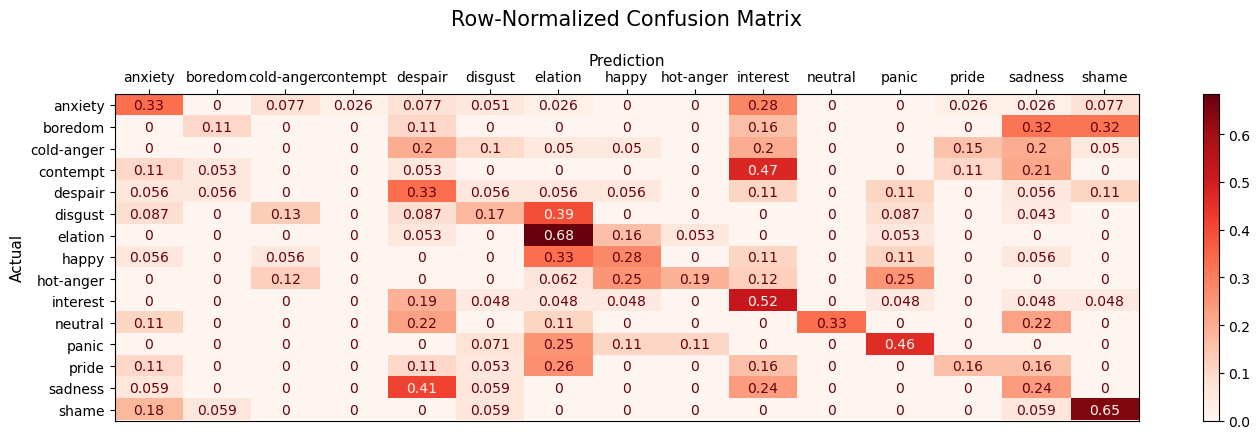

In [190]:
import matplotlib.pyplot as plt
cm=row_cm_normalized
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotions)
disp.plot(cmap=plt.cm.Reds)


plt.title('Row-Normalized Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)


#get current axis
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()
plt.gca().set_aspect('auto')
plt.subplots_adjust(left=12, right=14, bottom=0.2)

plt.show()